```
BEGIN ASSIGNMENT
init_cell: false
solutions_pdf: true
generate:
    seed: 42
    show_results: true
files:
    - defaults.csv
instructions: 'To submit this assignment, please upload both the IPYNB file for this notebook *and* the PDF generated by the cell below to Gradescope.'
```

Lab adapted from materials provided by the DATA88 staff, 
please check out that course for more statistical fun and exploring Econometrics.

# Lab 3: Data Science and Linear Regression

This lan focuses on the application of data science techniques from lecture. 
You will practice single variable ordinary least squares regression in the Data 8 style, 
go through a guided introduction to multivariate OLS using the package `scikit-learn`, 
and finally create your own multivariate OLS model.

After this lab, you should be able to

1. Write and apply the necesssary functions to perform single variable OLS
2. Use the `scikit-learn` package to create multivariate OLS models
3. Understand how to quantitatively evaluate models using the root-mean-squared error
4. Look for and use relationships between variables to select features for regression

In [ ]:
from datascience import *
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from ipywidgets import interact, Dropdown, IntSlider
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
#import otter
#grader = otter.Notebook()
plt.style.use('seaborn-muted')
%matplotlib inline
plt.rcParams["figure.figsize"] = [10,7]

In this lab, we will be working with data on credit card defaults and billing. The data covers April to September 2005, with one row for each cardholder. It has the following columns:

| Column | Description |
|-----|-----|
| `credit` | Total amount of credit |
| `sex` | Cardholder sex |
| `education` | Cardholder education level |
| `martial_status` | Cardholder marital status |
| `age` | Cardholder age |
| `bill_{month}05` | Bill amount for specific month |
| `paid_{month}05` | Amount paid in specified month |
| `default` | Whether the cardholder defaulted |

In the cell below, we load the dataset.

In [ ]:
defaults_raw = pd.read_csv("defaults.csv")
defaults_raw.head(5)

,credit,sex,education,marital_status,age,bill_sep05,bill_aug05,bill_jul05,bill_jun05,bill_may05,bill_apr05,paid_sep05,paid_aug05,paid_jul05,paid_jun05,paid_may05,paid_apr05,default
0,20000,female,undergraduate,married,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,female,undergraduate,single,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,female,undergraduate,single,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,female,undergraduate,married,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,male,undergraduate,married,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


**Question 0.1:** Which of the columns in `defaults_raw` would we need dummies for in order to use in an OLS model? Assign `q0_1` to an array of these column _labels_.

```
BEGIN QUESTION
name: q0_1
```

In [ ]:
q0_1 = ["sex", "education", "marital_status", "age"] # last is optional # SOLUTION
q0_1

['sex', 'education', 'marital_status', 'age']

In [ ]:
## Test ##
assert len(q0_1) in [3, 4]
assert "sex" in q0_1
assert "education" in q0_1
assert "marital_status" in q0_1
assert len(q0_1) == 3 or "age" in q0_1

In order to use the columns you chose, we will need to create dummies for them. In lecture, we showed a function (defined in the imports cell) that will get dummies for a variable for you.

**Question 0.2:** Use the `get_dummies` function to get dummies for the variables you listed in Question 0.1. _Make sure you drop the original columns using the `drop` argument._

```
BEGIN QUESTION
name: q0_2
```

In [ ]:
defaults = pd.get_dummies(defaults_raw, drop_first=True)             # SOLUTION
defaults

,credit,age,bill_sep05,bill_aug05,bill_jul05,bill_jun05,bill_may05,bill_apr05,paid_sep05,paid_aug05,...,paid_jun05,paid_may05,paid_apr05,default,sex_male,education_gradaute,education_other,education_undergraduate,marital_status_other,marital_status_single
0,20000,24,3913,3102,689,0,0,0,0,689,...,0,0,0,1,0,0,0,1,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,1000,0,2000,1,0,0,0,1,0,1
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,1000,1000,5000,0,0,0,0,1,0,1
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,1100,1069,1000,0,0,0,0,1,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,9000,689,679,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,188948,192815,208365,88004,31237,15980,8500,20000,...,3047,5000,1000,0,1,0,0,0,0,0
29996,150000,43,1683,1828,3502,8979,5190,0,1837,3526,...,129,0,0,0,1,0,0,0,0,1
29997,30000,37,3565,3356,2758,20878,20582,19357,0,0,...,4200,2000,3100,1,1,0,0,1,0,1
29998,80000,41,-1645,78379,76304,52774,11855,48944,85900,3409,...,1926,52964,1804,1,1,0,0,0,0,0


In [ ]:
## Test ##
assert "education" not in defaults.columns
assert "marital_status" not in defaults.columns
assert "sex_male" in defaults.columns

## Part 1: Single Variable OLS

We'll start by doing some single variable linear regression, ala Data 8. To begin, recall that we can model $y$ based on $x$ using the form

$$\Large
\hat{y} = \hat{\alpha} + \hat{\beta} x
$$

We can define the **correlation coefficient** of two values to be the mean of the product of their values in standard units.

**Question 1.1:** Complete the `corr` function below to compute the correlation coefficient of two arrays `x` and `y` based on the formula

$$\Large
r = \text{mean} \left ( x_\text{SU} \cdot y_\text{SU} \right )
$$

_Hint:_ You may find the `su` function, which converts an array to standard units, helpful.

```
BEGIN QUESTION
name: q1_1
```

In [ ]:
def su(arr):
    """Converts array arr to standard units"""
    return (arr - np.mean(arr)) / np.std(arr)

def corr(x, y):
    """Calculates the correlation coefficient of two arrays"""
    return np.mean(su(x) * su(y)) # SOLUTION

In [ ]:
## Test ##
np.random.seed(1234)
x2 = np.random.uniform(0, 10, 5)
y2 = np.random.uniform(0, 10, 5)
np.isclose(corr(x2, y2), 0.6410799722591175)

True

In [ ]:
## Hidden Test ##
np.random.seed(2345)
x2 = np.random.uniform(0, 10, 5)
y2 = np.random.uniform(0, 10, 5)
np.isclose(corr(x2, y2), -0.4008555019904271)

True

From this $r$ value that we have calculated above, we can compute the slope $\beta$ and intercept $\alpha$ of the best-fit line using the formulas below.

$$\Large
\beta = r \frac{\hat{\sigma}_y}{\hat{\sigma}_x}
\qquad \text{ and } \qquad
\alpha = \hat{\mu}_y - \beta \cdot \hat{\mu}_x
$$

**Question 1.2:** Using your `corr` function, fill in the `slope` and `intercept` functions below which compute the values of $\beta$ and $\alpha$ for the line of best fit that predicts `y` based on `x`. Your function should use array arithmetic (i.e. no `for` loops).

_Hint:_ You may find your `slope` function useful in `intercept`.

```
BEGIN QUESTION
name: q1_2
```

In [ ]:
def slope(x, y):
    """Computes the slope of the best-fit line of y based on x"""
    return np.std(y) * corr(x, y) / np.std(x) # SOLUTION

def intercept(x, y):
    """Computes the intercept of the best-fit line of y based on x"""
    return np.mean(y) - slope(x, y) * np.mean(x) # SOLUTION

In [ ]:
## Test ##
np.random.seed(1234)
x2 = np.random.uniform(0, 10, 5)
y2 = np.random.uniform(0, 10, 5)
np.isclose(slope(x2, y2), 0.853965497371089)

True

In [ ]:
## Test ##
np.random.seed(1234)
x2 = np.random.uniform(0, 10, 5)
y2 = np.random.uniform(0, 10, 5)
np.isclose(intercept(x2, y2), 1.5592892975597108)

True

In [ ]:
## Hidden Test ##
np.random.seed(2345)
x2 = np.random.uniform(0, 10, 5)
y2 = np.random.uniform(0, 10, 5)
np.isclose(slope(x2, y2), -0.5183482739336265)

True

In [ ]:
## Hidden Test ##
np.random.seed(2345)
x2 = np.random.uniform(0, 10, 5)
y2 = np.random.uniform(0, 10, 5)
np.isclose(intercept(x2, y2), 7.777051922080558)

True

Now let's look at how we can predict the `bill_sep05` column based on some other column of our data. We'll start by looking at the `credit` as the explanatory variable. To use our functions above, we must extract the values of each column as arrays, which we define below as `x` and `y`. We then compute the fitted values `y_hat` using the slope-intercept formula and plot the results.

**Question 1.3:** Using the functions you defined in Question 1.2, regress `bill_sep05` on `credit`. Assign your predictions to `y_hat`.

```
BEGIN QUESTION
name: q1_3
```

In [ ]:
x = defaults["credit"]
y = defaults["bill_sep05"]

beta = slope(x, y)           # SOLUTION
alpha = intercept(x, y)      # SOLUTION

y_hat = beta * x + alpha     # SOLUTION

In [ ]:
## Test ##
len(y_hat) == len(y)

True

In [ ]:
## Test ##
x.shape == (30000,)

True

In [ ]:
## Test ##
0.1 <= beta <= 0.2

True

In [ ]:
## Test ##
23000 <= alpha <= 25000

True

In [ ]:
## Hidden Test ##
np.isclose(beta, 0.16199038569776522)

True

In [ ]:
## Hidden Test ##
np.isclose(alpha, 24092.480872897704)

True

In [ ]:
## Hidden Test ##
np.random.seed(1234)
sub_y = np.random.choice(y_hat, 5)
np.allclose(sub_y, [48391.03872756, 28952.19244383, 87268.73129503, 58110.46186943, 32192.00015779])

True

Now that we have some predictions, let's plot the original data and the regression line.

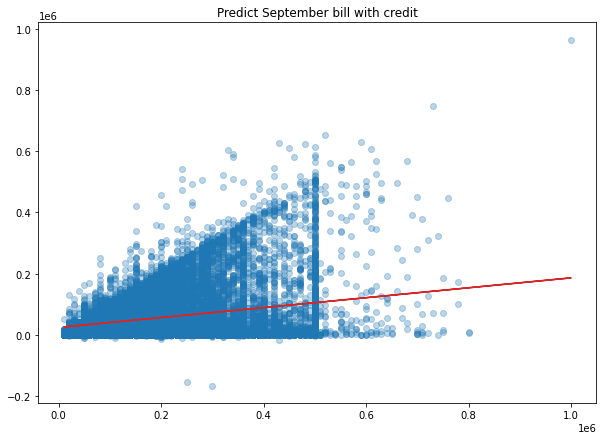

In [ ]:
plt.scatter(x, y, color="tab:blue", alpha=0.3)
plt.plot(x, y_hat, color="tab:red")
plt.title("Predict September bill with credit");

**Question 1.4:** Does the line we found fit the data well? Explain.

```
BEGIN QUESTION
name: q1_4
manual: true
```

<div class="alert alert-danger">

<strong>SOLUTION:</strong> Nope
    
</div>

Let's estimate how confident we are in the significance of our $\hat{\beta}$ coefficient.

**Question 1.5:** Fill in the code below to bootstrap our $\hat{\beta}$ and find the 95% confidence interval. Store the lower and upper bounds as `ci95_lower` and `ci95_upper`, respectively. (The cell may take a couple minutes to run.)

_Hint:_ Since we're only interested in $\hat{\beta}$, we don't need to find the intercept or fit our $x$ values.

```
BEGIN QUESTION
name: q1_5
```

In [ ]:
## Seed, don't worry about the code, this is just to make sure that randomness is controlled, and we can autograde your solution ##
np.random.seed(42)

betas = make_array()

for i in np.arange(200):
    sample = defaults.sample(5000)    # defaults is a huge table, so we'll only sample 5000 rows
    sample_x = sample["credit"]                       # SOLUTION
    sample_y = sample["bill_sep05"]                   # SOLUTION
    betas = np.append(betas, slope(sample_x, sample_y))      # SOLUTION

ci95_lower = percentile(2.5, betas)                          # SOLUTION
ci95_upper = percentile(97.5, betas)                         # SOLUTION

print("95% CI: ({}, {})".format(ci95_lower, ci95_upper))

95% CI: (0.14202532911896348, 0.18635000023686707)


In [ ]:
## Test ##
0.13 <= ci95_lower <= 0.17

True

In [ ]:
## Test ##
0.16 <= ci95_upper <= 0.20

True

In [ ]:
## Hidden Test ##
np.isclose(ci95_lower, 0.14202532911896348)

True

In [ ]:
## Hidden Test ##
np.isclose(ci95_upper, 0.18635000023686707)

True

**Question 1.6:** Using your 95% confidence interval, is it likely that the credit has no effect on the September 2005 bill? Justify your answer.

```
BEGIN QUESTION
name: q1_6
manual: true
```

<div class="alert alert-danger">

<strong>SOLUTION:</strong> No, the CI does not contain 0
    
</div>

Obviously, we can see that our best-fit line does not predict perfectly. There are plenty of points in the scatterplot that do not fall on the line. But how do we quantify the error of our model? There are many so-called *loss functions*, but in this notebook we will use the **root-mean-squared error**, which is defined as

$$\Large
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left ( y_i - \hat{y}_i \right ) ^2 }
$$

where $n$ is the number of observations. The effect of this is to take the mean of the distance of each value of $\hat{y}$ from its corresponding value in $y$; squaring these values keeps them positive, and then we take the square root to correct the units of the error.

**Question 1.7:** Complete the function `rmse` below which computes the root-mean-squared error of the prediction `y_hat` on `y`. Again, no `for` loops.

```
BEGIN QUESTION
name: q1_7
```

In [ ]:
def rmse(y, y_hat):
    """Computes the RMSE of prediction y_hat based on y"""
    return np.sqrt(np.mean((y - y_hat)**2)) # SOLUTION

In [ ]:
## Test ##
np.random.seed(1234)
y2 = np.random.uniform(0, 10, 5)
y_hat2 = np.random.uniform(0, 10, 5)
np.isclose(rmse(y2, y_hat2), 2.440102731334708)

True

In [ ]:
## Hidden Test ##
np.random.seed(2345)
y2 = np.random.uniform(0, 10, 5)
y_hat2 = np.random.uniform(0, 10, 5)
np.isclose(rmse(y2, y_hat2), 4.034226624125118)

True

**Question 1.8:** Use your `rmse` function to compute the RMSE of our prediction `y_hat` based on `y` from above.

```
BEGIN QUESTION
name: q1_8
```

In [ ]:
single_var_error = rmse(y, y_hat) # SOLUTION
single_var_error

70571.40305975602

In [ ]:
## Test ##
70000 <= single_var_error <= 80000

True

In [ ]:
## Hidden Test ##
np.isclose(single_var_error, 70571.40305975602)

True

Now that we know how to predict based on and quantify the error of a model, let's write a function that will encapsulate this pipeline for us.

**Question 1.9:** Fill in the function `pred_and_plot` below which models `bill_sep05` based on a column `col`, plots the scatterplot and line of best fit, and computes the RMSE of the model. Then choose a column you think might be related to `bill_sep05` and use your `pred_and_plot` function to determine its prediction RMSE and plot the regression line.

_Hint:_ Your code from Question 1.3 may be helpful here...

```
BEGIN QUESTION
name: q1_9
manual: true
```

RMSE: 72440.79127


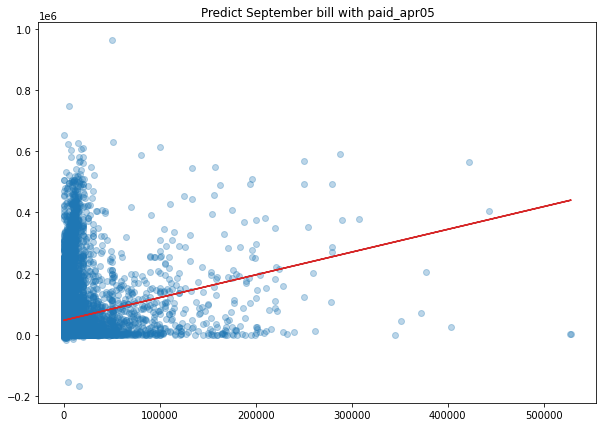

In [ ]:
def pred_and_plot(col):
    """Performs single variable OLS to predict bill_sep05 based on col"""
    x = defaults[col]           # SOLUTION
    y = defaults["bill_sep05"]  # SOLUTION

    beta = slope(x, y)                 # SOLUTION
    alpha = intercept(x, y)            # SOLUTION

    y_hat = beta * x + alpha           # SOLUTION
    
    model_rmse = rmse(y, y_hat)        # SOLUTION
    
    
    ### DO NOT EDIT THE REST OF THIS FUNCTION ###
    print("RMSE: {:.5f}".format(rmse(y, y_hat)))

    plt.scatter(x, y, color="tab:blue", alpha=0.3)
    plt.plot(x, y_hat, color="tab:red")
    plt.title("Predict September bill with {}".format(col))


### Provide your column name below ###
pred_and_plot("paid_apr05")

In looking through different features, you should have noticed that most of them don't follow a linear relationship very well. In practice, you often need _multiple_ features (explanatory variables) to predict an outcome variable, and it is for this reason that we often use **multiple linear regression** to predict variables.

Finally, before moving on to the multivariable case, let's think about using whether or not an individual defaults as a predictor of their September 2005 bill.

**Question 1.10:** Assign `default_beta` and `default_alpha` to the slope and intercept of your regression of `bill_sep05` on the `default` column of the table `defaults`.

_Hint:_ Our outcome variable hasn't changed, so we can reuse the array `y` defined earlier.

```
BEGIN QUESTION
name: q1_10
```

In [ ]:
default_x = defaults["default"]      # SOLUTION

default_beta = slope(default_x, y)          # SOLUTION
default_alpha = intercept(default_x, y)     # SOLUTION

print("y_hat = {} * x + {}".format(default_beta, default_alpha))

y_hat = -3485.0649761630766 * x + 51994.22727272727


In [ ]:
## Test ##
-4000 <= default_beta <= -3000

True

In [ ]:
## Test ##
51000 <= default_alpha <= 52000

True

In [ ]:
## Hidden Test ##
np.isclose(default_beta, -3485.0649761630766)

True

In [ ]:
## Hidden Test ##
np.isclose(default_alpha, 51994.22727272727)

True

**Question 1.11:** Interpret the value of `default_beta`. Basically, what do we expected to happen when `default` changes from 0 to 1? Explain.

```
BEGIN QUESTION
name: q1_11
manual: true
```

<div class="alert alert-danger">

<strong>SOLUTION:</strong> We expect the bill to go down by approx \\$3,485
    
</div>

## Part 2: Guided Multivariable OLS

When we predict a variable $y$ based on some set of $p$ explanatory variables $x$, we create a set of weights $\alpha$ and $\beta_i$ such that we have

$$\Large
y = \alpha + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \varepsilon
$$

Because of the error term $\varepsilon$, we will instead create predictions $\hat{y}$, such that 

$$\Large
\hat{y} = \alpha + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + \cdots + \hat{\beta}_p x_p
$$

Let's model the September bill based on the other bills in the data set (April to August). Recall from lecture that we can model an outcome variable `Y` based on columns from our data `defaults` by extracting the values of the table into an array. In the cell below, we create the arrays `X` and `Y`.

In [ ]:
X = defaults[["bill_aug05", "bill_jul05", "bill_jun05", "bill_may05", "bill_apr05"]]
Y = defaults["bill_sep05"]

Recall that we can fit a multivariate OLS model using `statsmodels` by calling the function `sm.OLS` on the outcome and explanatory variables. In the cell below, we create a model based on _all_ the columns in the table (except, of course, the outcome variable).

In [ ]:
# create an OLS object with the data
model = lm.LinearRegression()
model.fit(X, Y)
model.coef_

array([0.91099773, 0.04184977, 0.0227457 , 0.01551302, 0.00834073])

**Question 2.1:** Which beta coefficient corresponds to `bill_jul05`?

<ol style="list-style-type: lower-alpha;">
    <li>0.91099773</li>
    <li>0.04184977</li>
    <li>0.0227457</li>
    <li>0.01551302</li>
    <li>0.00834073</li>
</ol>

Assign your answer to `q2_1` below.

```
BEGIN QUESTION
name: q2_1
```

In [ ]:
q2_1 = "b" # SOLUTION

In [ ]:
## Test ##
q2_1 in ["a", "b", "c", "d", "e"]

True

In [ ]:
## Hidden Test ##
q2_1 == "b"

True

**Question 2.2:** Which three bills are better predictors of `bill_sep05` from the five bills selected? Justify your response.


```
BEGIN QUESTION
name: q2_2
manual: true
```

<div class="alert alert-danger">

<strong>SOLUTION:</strong> August, July, and June. These are the largest positive coefficients.
    
</div>

Now let's look and see what values our model predicts for our outcome variable. Recall that we can extract the fitted values from the result using `model.predict`. 

**Question 2.3:** Assign `Y_hat` to the fitted values of `model`. Then assign `multi_rmse` to the RMSE of this prediction based on `Y`.

```
BEGIN QUESTION
name: q2_3
```

In [ ]:
Y_hat = model.predict(X)    # SOLUTION

multi_rmse = rmse(Y, Y_hat)    # SOLUTION
multi_rmse

22561.189743524323

In [ ]:
## Test ##
len(Y_hat) == defaults.shape[0]

True

In [ ]:
## Test ##
22000 <= multi_rmse <= 23000

True

In [ ]:
## Hidden Test ##
np.random.seed(1234)
expected = np.array([131575.00462172,  26777.22647566,   2573.18036936,   2824.68190761, 50299.39627643])
actual = np.random.choice(Y_hat, 5)
np.allclose(expected, actual)

True

In [ ]:
## Hidden Test ##
np.isclose(multi_rmse, 22561.189743524323)

True

We see from this RMSE that the prediction is (much) better than the single variable case, but it's still not too good. Let's try and select better features to see if we can lower our RMSE.

**Question 2.4:** What might be a good way to select columns that would lower our prediction RMSE? What kinds of characteristics and relationships should we look for in our feature columns?

```
BEGIN QUESTION
name: q2_4
manual: true
```

<div class="alert alert-danger">
    
<strong>SOLUTION:</strong> In general, since we are using <em>linear</em> regression, variables that are more correlated with the outcome variable are better features (and serve to lower RMSE).

</div>

**Question 2.5:** Add one more column label to the array `new_features` below. Then fill in the code below to create a new OLS model based on the columns in `new_features`, storing the fitted values in `new_Y_hat`.

_Hint:_ Our outcome variable `Y` hasn't changed, so we can reuse the same array as earlier.

```
BEGIN QUESTION
name: q2_5
```

Now that you have thought about what might make good features, let's implement a new model to see how well we can do.

In [ ]:
# BEGIN SOLUTION NO PROMPT
new_features = make_array("bill_aug05", "bill_jul05", "bill_jun05", "bill_may05", "bill_apr05", "credit")
# END SOLUTION

""" # BEGIN PROMPT
new_features = make_array("bill_aug05", "bill_jul05", "bill_jun05", "bill_may05", "bill_apr05", ...)
""" # END PROMPT

new_X = defaults[new_features]     # SOLUTION

new_model = lm.LinearRegression().fit(new_X, Y)    # SOLUTION
new_Y_hat = new_model.predict(new_X)              # SOLUTION
new_Y_hat

array([ 4048.90715865,  4114.37424134, 15896.45055349, ...,
        5317.3077061 , 77924.10765779, 49396.63415292])

In [ ]:
## Test ##
len(new_features) == 6

True

In [ ]:
## Test ##
new_X.shape[1] == 6

True

In [ ]:
## Test ##
len(new_Y_hat) == defaults.shape[0]

True

Now that we have some predictions, let's look at the accuracy of our model.

**Question 2.6:** Calculate the RMSE of `new_Y_hat` based on `Y` and store this value as `new_rmse`.

```
BEGIN QUESTION
name: q2_6
```

In [ ]:
new_rmse = rmse(Y, new_Y_hat) # SOLUTION
new_rmse

22520.134070208653

In [ ]:
## Test ##
22000 <= new_rmse <= 23000

True

In [ ]:
## Hidden Test ##
np.isclose(new_rmse, 22520.134070208653)

True

**Question 2.7:** Did the RMSE go up or down in Question 2.6 compared to Question 2.3? Why do you think so?

```
BEGIN QUESTION
name: q2_7
manual: true
```

<div class="alert alert-danger">
    
<strong>SOLUTION:</strong> You will get full points as long as you provide a good reason for why you think your RMSE went up or down.

</div>

## Part 3: Unguided Multivariable OLS

In this section of the assignment, you will use `sklearn` and OLS to create your own model to predict the September 2005 bill based on 5000 sample of the data,
 and testing that model's accuracy on another 1000 sample of the data. 
Your model will be scored out of **5 points**, and a portion of your score will be determined based on your RMSE. The scores you will receive are given in the table below.

| RMSE | Score (out of 5) |
|-----|-----|
| $\le$ 25,000 | 6 |
| $\le$ 30,000 | 5 |
| $\le$ 50,000 | 4 |
| $\le \infty$ | 3 |

Note that it is possible to receive a 6 out of 5 for an especially good model, and that as long as you *create a model*, you are guaranteed a 3 out of 5. **To submit your model, you must assign `my_labels` to an array of the columns you want your model to use. You may not use more than 10 columns and, of course, you can't use the column `bill_sep05` in your features.** Your model RMSE will be calculated using the following code:

```python
X, Y = defaults[my_labels], defaults["bill_sep05"]
train = defaults.sample(5000, replace = False, random_state = 234)
train_X = train[my_labels]
train_Y = train["bill_sep05"]

test = defaults.sample(1000, replace = False, random_state = 234)
test_X = test[my_labels]
test_y = test["bill_sep05"]


model = lm.LinearRegression().fit(train_X, train_Y)
Y_hat = model.predict(test_X)
rmse(test_Y, Y_hat)
```

To select your features, use the widget below to look for correlations between variables and the September 2005 bill. It requires your `pred_and_plot` function to work, so you will need to finish that function before using the widget.

In [ ]:
train = defaults.sample(5000, replace = False, random_state = 234)

test = defaults.sample(1000, replace = False, random_state = 234)

RMSE: 70571.40306


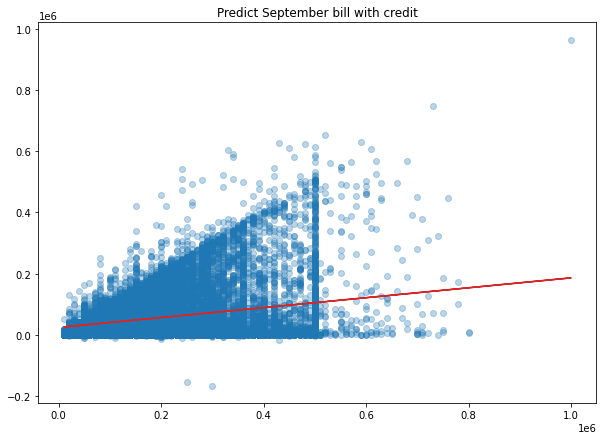

In [ ]:
interact(pred_and_plot, col=Dropdown(options=train.columns));

Add and remove cells below as needed, but *make sure you define `my_labels`*. We have provided code for you to create your `X` array; just fill in the `...` in `my_labels` with your columns and use the space at the bottom to work on your model. Good luck!

```
BEGIN QUESTION
name: q3
points: 3
```

In [ ]:
""" # BEGIN PROMPT
my_labels = make_array(...)

train_X = train[...]
train_Y = train[...]
test_X = ...
test_Y = ...
my_model = ...
my_Y_hat = ...
rmse(...)
# END PROMPT
"""
# BEGIN SOLUTION NO PROMPT
my_labels = ['bill_aug05','bill_jun05','bill_may05','bill_apr05','paid_sep05',
                       'paid_aug05','paid_jul05','paid_jun05','paid_may05','paid_apr05']

train_X = train[my_labels]
train_Y = train["bill_sep05"]
test_X = test[my_labels]
test_Y = test["bill_sep05"]
my_model = lm.LinearRegression().fit(train_X, train_Y)
my_Y_hat = my_model.predict(test_X)
rmse(test_Y, my_Y_hat)
# END SOLUTION



20407.901899115393

In [ ]:
## Test ##
len(my_labels) <= 10

True

In [ ]:
## Test ##
"bill_sep05" not in my_labels

True

```
BEGIN QUESTION
name: q3_1
```

In [ ]:
## Hidden Test ##
my_X = defaults[my_labels]
my_model = lm.LinearRegression().fit(my_X, Y)
my_Y_hat = my_model.predict(my_X)
rmse(Y, my_Y_hat) <= 50000

True

```
BEGIN QUESTION
name: q3_2
```

In [ ]:
## Hidden Test ##
my_X = defaults[my_labels]
my_model = lm.LinearRegression().fit(my_X, Y)
my_Y_hat = my_model.predict(my_X)
rmse(Y, my_Y_hat) <= 30000

True

```
BEGIN QUESTION
name: q3_3
```

In [ ]:
## Hidden Test ##
my_X = defaults[my_labels]
my_model = lm.LinearRegression().fit(my_X, Y)
my_Y_hat = my_model.predict(my_X)
rmse(Y, my_Y_hat) <= 25000


True

## Part 4: Reflection

In this section of the assignment, you will answer some conceptual questions about the choices you made in creating your model in Part 3. 
**This section heavily influences your grade, as we are looking to ensure that you are using intuition while modeling. Please answer thoughtfully and *show us the numbers*.**

**Question 4.1:** Explain one choice you made in selecting features while modeling in Part 3 and why you made it. (Your explanation should take at least a few sentences, and should justify your choice mathematically (i.e. with numerical evidence).)

```
BEGIN QUESTION
name: q4_1
manual: true
```

<div class="alert alert-danger">
    
<strong>SOLUTION:</strong> You should describe a choice you made and give mathematical justifications for why you made it. For example, I replace feature A with feature B because A's correlation with $y$ was \_\_\_\_\_ but B's was \_\_\_\_\_, and this lowered the RMSE from \_\_\_\_\_ to \_\_\_\_\_.

Basically, show me the numbers.

</div>

**Question 4.2:** Use your `pred_and_plot` function in the cell below to generate a visualization that helped you choose a feature in Part 3.

```
BEGIN QUESTION
name: q4_2
manual: true
```

RMSE: 43919.38150


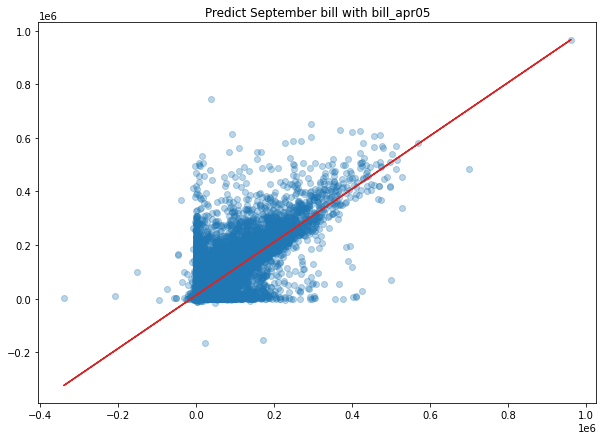

In [ ]:
pred_and_plot("bill_apr05") # SOLUTION

**Question 4.3:** Why do we train and test on different subsets of our data? Wouldn't our model be more effective if we trained on the entire dataset? Explain.

```
BEGIN QUESTION
name: q4_3
manual: true
```

<div class="alert alert-danger">
    
<strong>SOLUTION:</strong> 
Training and testing on the same data will give a higher accuracy then what the model is going to perform in the real world. 
This is concerning since it will give us too high of a confidence in our model, and may lead to erroneous conclusions about our data. 

</div>

---

### References

* Data from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#